In [5]:
# ------------------------------------------------------------
# Step 1 · Imports and Paths (Male & Female)
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt

# Define base path
base_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand")

# CSV paths for male and female population data
csv_male_fp = base_path / "data/raw/continuous_age/lsoa_age_by_year_male_2024.csv"
csv_female_fp = base_path / "data/raw/continuous_age/lsoa_age_by_year_female_2024.csv"

# LSOA boundary GeoPackage (enriched version with clipped South West data)
gpkg_fp = base_path / "data/processed/lsoa_south_west_enriched.gpkg"


In [6]:
# ------------------------------------------------------------
# Step 2 · Load Files (Male & Female)
# ------------------------------------------------------------
# Load age CSVs
df_male = pd.read_csv(csv_male_fp)
df_female = pd.read_csv(csv_female_fp)

# Load LSOA GeoDataFrame
gdf_lsoa = gpd.read_file(gpkg_fp)

# Print shapes and column names for inspection
print(f"[Male CSV] Rows: {df_male.shape[0]}, Columns: {df_male.shape[1]}")
print(f"[Male CSV] Columns: {list(df_male.columns)}\n")

print(f"[Female CSV] Rows: {df_female.shape[0]}, Columns: {df_female.shape[1]}")
print(f"[Female CSV] Columns: {list(df_female.columns)}\n")

print(f"[LSOA GPKG] Rows: {gdf_lsoa.shape[0]}, Columns: {gdf_lsoa.shape[1]}")
print(f"CRS of GPKG: {gdf_lsoa.crs}")


[Male CSV] Rows: 3472, Columns: 92
[Male CSV] Columns: ['lsoa_code', 'lsoa_name', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89']

[Female CSV] Rows: 3472, Columns: 92
[Female CSV] Columns: ['lsoa_code', 'lsoa_name', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',

In [7]:
# ------------------------------------------------------------
# Step 3 · Fix Invalid Geometry in LSOA GPKG
# ------------------------------------------------------------
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def extract_valid_geom(geom):
    if isinstance(geom, (Polygon, MultiPolygon)):
        return geom
    elif isinstance(geom, GeometryCollection):
        # Extract first Polygon or MultiPolygon from collection if exists
        polys = [g for g in geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
        return polys[0] if polys else None
    else:
        return None

# Clean geometries
gdf_lsoa["geometry"] = gdf_lsoa["geometry"].apply(extract_valid_geom)

# Drop rows with invalid geometries
gdf_lsoa = gdf_lsoa[gdf_lsoa["geometry"].notnull()].copy()

print(f"Geometry cleaned. Remaining valid geometries: {len(gdf_lsoa)}")


Geometry cleaned. Remaining valid geometries: 3451


In [8]:
# ------------------------------------------------------------
# Step 4 · Prepare Age CSVs (Already Wide Format by LSOA)
# ------------------------------------------------------------

def clean_age_df(df, label):
    # Step 4a · Strip whitespace from string columns
    df["lsoa_code"] = df["lsoa_code"].str.strip()
    df["lsoa_name"] = df["lsoa_name"].str.strip()

    # Step 4b · Ensure all age columns are strings
    df.columns = ["lsoa_code", "lsoa_name"] + [str(col).strip() for col in df.columns[2:]]

    # Step 4c · Print summary
    print(f"[{label}] Age DataFrame shape: {df.shape}")
    print(df.head(2), "\n")
    return df

# Apply to both male and female
df_male = clean_age_df(df_male, "Male")
df_female = clean_age_df(df_female, "Female")


[Male] Age DataFrame shape: (3472, 92)
   lsoa_code           lsoa_name     0     1     2     3     4     5     6  \
0  E01014014  Herefordshire 018C  3.06  3.06  6.13  8.17  7.15  6.13  2.04   
1  E01014031  Herefordshire 023A  4.08  5.11  3.06  3.06  6.13  4.08  4.08   

      7  ...     80    81    82    83    84    85    86    87    88    89  
0  6.13  ...   9.19  9.19  5.11  7.15  3.06  3.06  1.02  0.00  6.13  4.08  
1  9.19  ...  12.25  5.11  7.15  6.13  6.13  3.06  5.11  7.15  4.08  2.04  

[2 rows x 92 columns] 

[Female] Age DataFrame shape: (3472, 92)
   lsoa_code           lsoa_name     0     1     2     3     4     5     6  \
0  E01014014  Herefordshire 018C  6.13  7.15  7.15  5.11  9.19  7.15  6.13   
1  E01014031  Herefordshire 023A  3.06  3.06  9.19  8.17  2.04  7.15  8.17   

      7  ...    80    81    82     83    84    85    86    87    88    89  
0  6.13  ...  4.08  4.08  7.15  10.21  4.08  2.04  5.11  2.04  2.04  2.04  
1  5.11  ...  8.17  9.19  1.02   6.13  7.15  

In [9]:
# ------------------------------------------------------------
# Step 5 · Join Age Data (Male & Female) to LSOA GeoDataFrame
# ------------------------------------------------------------

# Optional: check join key in LSOA GeoDataFrame
print("LSOA GeoDataFrame columns:", gdf_lsoa.columns.tolist())

# Perform joins
gdf_male = gdf_lsoa.merge(
    df_male,
    how="left",
    left_on="lsoa21cd",  # Assumes this is the LSOA code in GeoDataFrame
    right_on="lsoa_code"
)

gdf_female = gdf_lsoa.merge(
    df_female,
    how="left",
    left_on="lsoa21cd",
    right_on="lsoa_code"
)

# Inspect outputs
print(f"[Male] Joined GeoDataFrame shape: {gdf_male.shape}")
print(gdf_male.head(2), "\n")

print(f"[Female] Joined GeoDataFrame shape: {gdf_female.shape}")
print(gdf_female.head(2))


LSOA GeoDataFrame columns: ['lsoa21cd', 'lsoa21nm_x', 'lsoa21nmw', 'bng_e', 'bng_n', 'lat', 'long', 'shape__are', 'shape__len', 'globalid', 'lsoa21nm_y', 'msoa21cd', 'msoa21nm', 'ladcd', 'ladnm', 'geometry']
[Male] Joined GeoDataFrame shape: (3451, 108)
    lsoa21cd          lsoa21nm_x lsoa21nmw   bng_e   bng_n       lat     long  \
0  E01014014  Herefordshire 018C      None  363652  243381  52.08759 -2.53190   
1  E01014031  Herefordshire 023A      None  354699  217612  51.85525 -2.65915   

     shape__are    shape__len                              globalid  ...  \
0  5.488187e+07  58635.757515  8fce111a-0aab-4f99-8777-1ed10d8b04b0  ...   
1  1.949198e+07  28805.195706  77655486-1b21-4c99-a981-4f2fdb43ed95  ...   

      80    81    82    83    84    85    86    87    88    89  
0   9.19  9.19  5.11  7.15  3.06  3.06  1.02  0.00  6.13  4.08  
1  12.25  5.11  7.15  6.13  6.13  3.06  5.11  7.15  4.08  2.04  

[2 rows x 108 columns] 

[Female] Joined GeoDataFrame shape: (3451, 108)
    

In [10]:
# ------------------------------------------------------------
# Step 5a · Inspect Merged Outputs (Male & Female)
# ------------------------------------------------------------

def inspect_joined_gdf(gdf, label):
    print(f"\n[{label}] Joined GeoDataFrame shape: {gdf.shape}")

    print(f"\nColumns in {label} GeoDataFrame:")
    for col in gdf.columns:
        print(f" - {col}")

    # Check for duplicate columns
    duplicates = gdf.columns[gdf.columns.duplicated()]
    if duplicates.any():
        print(f"\nDuplicated columns in {label}: {duplicates.tolist()}")
    else:
        print(f"\nNo duplicated columns in {label} GeoDataFrame.")

    print(f"\nPreview of {label} GeoDataFrame (first 2 rows):")
    print(gdf.head(2).to_string(index=False))

# Inspect both
inspect_joined_gdf(gdf_male, "Male")
inspect_joined_gdf(gdf_female, "Female")



[Male] Joined GeoDataFrame shape: (3451, 108)

Columns in Male GeoDataFrame:
 - lsoa21cd
 - lsoa21nm_x
 - lsoa21nmw
 - bng_e
 - bng_n
 - lat
 - long
 - shape__are
 - shape__len
 - globalid
 - lsoa21nm_y
 - msoa21cd
 - msoa21nm
 - ladcd
 - ladnm
 - geometry
 - lsoa_code
 - lsoa_name
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
 - 10
 - 11
 - 12
 - 13
 - 14
 - 15
 - 16
 - 17
 - 18
 - 19
 - 20
 - 21
 - 22
 - 23
 - 24
 - 25
 - 26
 - 27
 - 28
 - 29
 - 30
 - 31
 - 32
 - 33
 - 34
 - 35
 - 36
 - 37
 - 38
 - 39
 - 40
 - 41
 - 42
 - 43
 - 44
 - 45
 - 46
 - 47
 - 48
 - 49
 - 50
 - 51
 - 52
 - 53
 - 54
 - 55
 - 56
 - 57
 - 58
 - 59
 - 60
 - 61
 - 62
 - 63
 - 64
 - 65
 - 66
 - 67
 - 68
 - 69
 - 70
 - 71
 - 72
 - 73
 - 74
 - 75
 - 76
 - 77
 - 78
 - 79
 - 80
 - 81
 - 82
 - 83
 - 84
 - 85
 - 86
 - 87
 - 88
 - 89

No duplicated columns in Male GeoDataFrame.

Preview of Male GeoDataFrame (first 2 rows):
 lsoa21cd         lsoa21nm_x lsoa21nmw  bng_e  bng_n      lat     long   shape__are   shape__le

In [14]:
# ------------------------------------------------------------
# Step 7 · Save Final GeoDataFrames to GPKG (Male & Female)
# ------------------------------------------------------------

# Explicitly define output directory
output_dir = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master")
output_dir.mkdir(parents=True, exist_ok=True)

# Define file paths
male_fp = output_dir / "LSOA_continuous_age_male_2024.gpkg"
female_fp = output_dir / "LSOA_continuous_age_female_2024.gpkg"

# Save GeoPackages
gdf_male.to_file(male_fp, driver="GPKG")
gdf_female.to_file(female_fp, driver="GPKG")

# Confirm saved paths
print("\nFinal GeoPackages saved to:")
print(" -", male_fp)
print(" -", female_fp)



Final GeoPackages saved to:
 - /Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master/LSOA_continuous_age_male_2024.gpkg
 - /Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master/LSOA_continuous_age_female_2024.gpkg


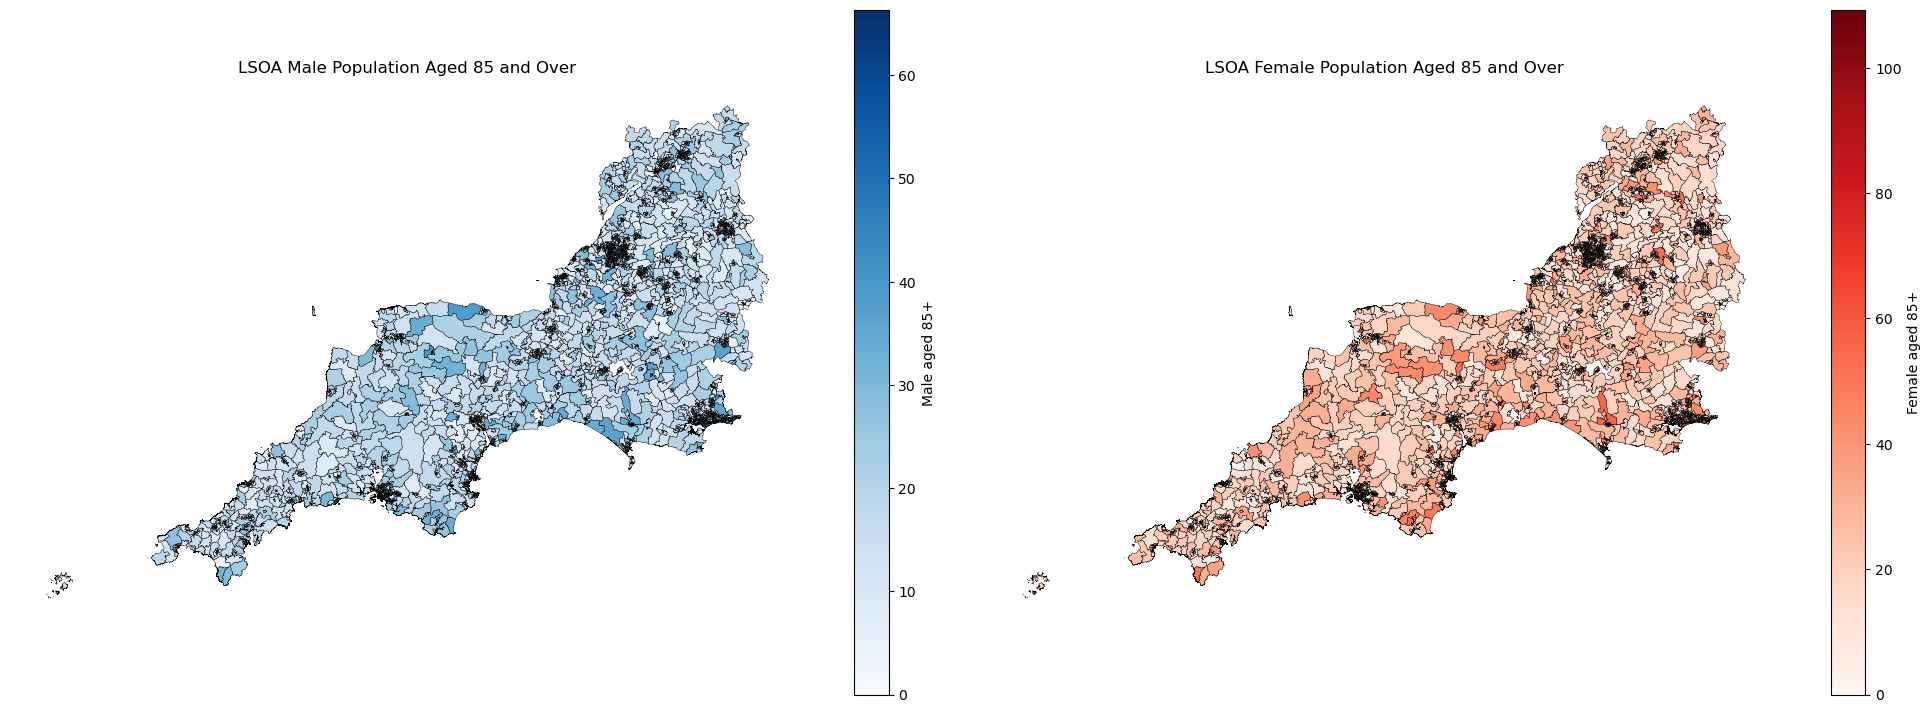

In [15]:
# ------------------------------------------------------------
# Visualise Side-by-Side: LSOA Population Aged 85 and Over
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Step 1: Add '85_and_over' column to both GeoDataFrames
for gdf, label in [(gdf_male, "Male"), (gdf_female, "Female")]:
    gdf["85_and_over"] = gdf[[str(age) for age in range(85, 90)]].sum(axis=1)

# Step 2: Side-by-side plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 14))

gdf_male.plot(
    column="85_and_over",
    cmap="Blues",
    legend=True,
    legend_kwds={"label": "Male aged 85+", "shrink": 0.5},
    ax=axes[0],
    edgecolor="black",
    linewidth=0.3
)
axes[0].set_title("LSOA Male Population Aged 85 and Over")
axes[0].axis("off")

gdf_female.plot(
    column="85_and_over",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Female aged 85+", "shrink": 0.5},
    ax=axes[1],
    edgecolor="black",
    linewidth=0.3
)
axes[1].set_title("LSOA Female Population Aged 85 and Over")
axes[1].axis("off")

plt.tight_layout()
plt.show()
